# This notebook explores how to train an MLP model to solve the Seismic task

##  1. Instantiating the datamodule object and preparing the data

Here the batch size is important to test out, if you have access to a memory rich gpu you can increase the batch size. If not decrease the batch size to avoid memory errors.

Training this model in cpu is not recommended as it will take a lot of time to train. If you don't have access to a gpu, you can use the kaggle or colab gpu notebooks to train the model.

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Flags to control wether or not to run unity tests and to show predictions.
run_unity_tests = True
show_predictions = True

In [2]:
from data_modules.seismic import F3SeismicDataModule

# Instantiating the HarDataModule with root dir at data/example
my_data_module = F3SeismicDataModule("data/", batch_size=4)

## 2. Retrieving the training and validation set dataloaders

Besides defining the batch size, the data module manages the data loaders for the training, validation, and test partitions. 
The next command shows how to retrieve the training and validation data loaders.

In [3]:
# Retrieve the training set dataloader (dl)
train_dl = my_data_module.train_dataloader()
val_dl = my_data_module.val_dataloader()

## 3. Creating the ML model



In [4]:
import models.deeplabv3 as dlv3
backbone = dlv3.DeepLabV3Backbone()

if run_unity_tests:
    # Generate batch with 2 random 255x701 RGB images (B x C x H x W)
    random_input = torch.rand(2,3,255,701).to(device=device)
    backbone.to(device=device)
    z = backbone(random_input)
    output_shape = z.shape
    print("output_shape = ", output_shape)
    print("output flatten dim = ", torch.flatten(z).shape)

output_shape =  torch.Size([2, 2048, 32, 88])
output flatten dim =  torch.Size([11534336])


In [5]:
import models.deeplabv3 as dlv3

model = dlv3.DeepLabV3Model(backbone=backbone, num_classes=6)
model.to(device=device)

if run_unity_tests:
    output = model(random_input)
    print("output_shape = ", output.shape)


output_shape =  torch.Size([2, 6, 255, 701])


## 4. Test the untrained model

First, lets test the model in a very detailed way, so we can inspect the shape of the tensors being processed and produced.
NOTE: the model has not been trained yet, hence, we expect very poor results.


-- Processing the batch 0
 predictions.shape =  torch.Size([4, 1, 255, 701])
 y.shape =  torch.Size([4, 1, 255, 701])
 predictions =  tensor([[[[0, 0, 0,  ..., 4, 4, 4],
          [0, 0, 0,  ..., 4, 4, 4],
          [0, 0, 0,  ..., 4, 4, 4],
          ...,
          [4, 4, 4,  ..., 0, 0, 0],
          [4, 4, 4,  ..., 0, 0, 0],
          [4, 4, 4,  ..., 0, 0, 0]]],


        [[[4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4],
          ...,
          [4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4]]],


        [[[0, 0, 0,  ..., 4, 4, 4],
          [0, 0, 0,  ..., 4, 4, 4],
          [0, 0, 0,  ..., 4, 4, 4],
          ...,
          [4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4]]],


        [[[4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4],
          ...,
          [4, 4, 4,  ..., 1, 1, 1],
  

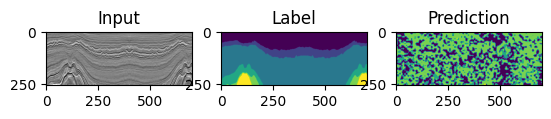

-- Processing the batch 1
batch IoU =  tensor(0.0405)


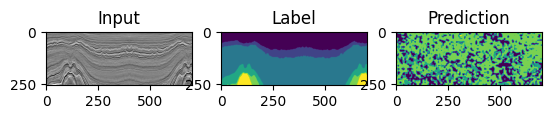

-- Processing the batch 2
batch IoU =  tensor(0.0416)


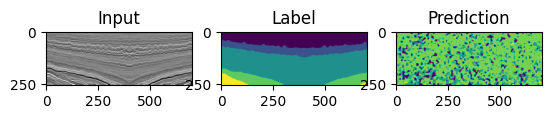

-- Processing the batch 3
batch IoU =  tensor(0.0387)


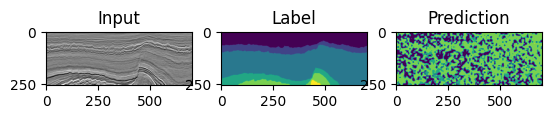

-- Processing the batch 4
batch IoU =  tensor(0.0391)


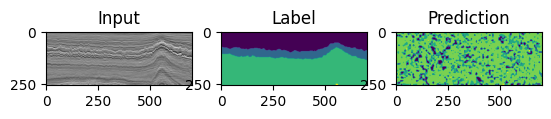

-- Processing the batch 5
batch IoU =  tensor(0.0385)


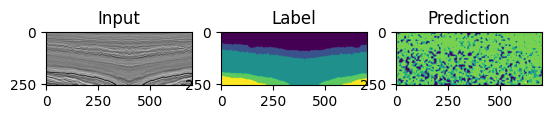

mIoU =  tensor(0.0409)


In [6]:
import torch
from matplotlib import pyplot as plt
from torchmetrics import JaccardIndex

# Initialize the JaccardIndex metric
jaccard = JaccardIndex(task="multiclass",num_classes=6)

# For each batch, compute the predictions and compare with the labels.
for batch_idx, (X, y) in enumerate(train_dl):

    print(f"-- Processing the batch {batch_idx}")

    # X and y contains the input features and the expected labels for the B samples in the batch

    model.to(device) # Move the model to the GPU if available
    X = X.to(device) # Move the input data to the GPU if available
    logits = model(X.float())  # Convert input tensor to float precision and run the model
    predictions = torch.argmax(logits, dim=1, keepdim=True) # The class with the highest logit is the prediction
    predictions = predictions.to("cpu")  # Move results back to CPU

    # Print the shape of the predictions tensor just for the first batch
    if batch_idx == 0:
        # Now, we have predictions for each one of the B input samples.
        # Lets print the shape of the predictions tensor and print the predictions themselves.
        print(" predictions.shape = ", predictions.shape)
        print(" y.shape = ", y.shape)
        print(" predictions = ", predictions)

        # Finally, lets compare the predictions against the expected labels
        correct = (predictions == y)
        print(" labels      = ", y)
        print(" correct     = ", correct)

    # Next, lets count the total number of correct predictions and the total number of predictions.
    iou = jaccard(predictions, y)
    print("batch IoU = ", iou)

    if show_predictions:
        # lets plot the first sample in the batch and its corresponding label and prediction
        plt.figure()
        plt.subplot(1, 3, 1)
        plt.imshow(X[0, 0, :, :].to("cpu").numpy(), cmap="gray")
        plt.title("Input")
        plt.subplot(1, 3, 2)
        plt.imshow(y[0, :, :].numpy().transpose(1, 2, 0))
        plt.title("Label")
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, 0, :, :].numpy())
        plt.title("Prediction")
        plt.show()

    # Stop after 6 batches
    if batch_idx == 5:
        break

print("mIoU = ", jaccard.compute())

Take some time to inspect the output of the previous code block and make sure it makes sense.
Next, lets perform the same test, but without printing all the intermediate values.
We will also encapsulate the code in a function so we can reuse it later.

In [7]:
def evaluate_model(model, dataset_dl):
    # Inicialize JaccardIndex metric
    jaccard = JaccardIndex(task="multiclass", num_classes=6)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # For each batch, compute the predictions and compare with the labels.
    for X, y in dataset_dl:
        # Move the model, data and metric to the GPU if available
        model.to(device)
        X = X.to(device)
        y = y.to(device)
        jaccard.to(device)

        logits = model(X.float())
        predictions = torch.argmax(logits, dim=1, keepdim=True)
        jaccard(predictions, y)
    # Return a tuple with the number of correct predictions and the total number of predictions
    return (float(jaccard.compute().to("cpu")))

def report_accuracy(model, dataset_dl, prefix=""):
    iou = evaluate_model(model, dataset_dl)
    print(prefix + " IoU = {:0.4f}".format(iou))

In [8]:
report_accuracy(model, train_dl, prefix="Training dataset")
report_accuracy(model, val_dl, prefix="Validation dataset")

Training dataset IoU = 0.0410
Validation dataset IoU = 0.0399


## 5. Train the model using PyTorch

In this section, we will explore how a model is trained with pytorch.

First, lets define the optimizer and the loss function.

In [9]:
# We will employ pytorch SGD optimizer. We must provide it with the model parameters and the learning rate.
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

Now, lets instanciate the loss function. In this case, we will employ the pytorch CrossEntropyLoss function.

In [10]:
loss_fn = torch.nn.CrossEntropyLoss()

Training the model involves:

- Making predictions on the training samples.
- Calculating the gradients with respect to the loss functions.
- Adjusting the model parameters by applying the gradients scaled by the learning rate.

Lets first try it on a single batch.

In [11]:
# Fetch the first batch
first_batch = next(iter(train_dl))
# Fetch the first element on the batch (X_0, y_0)
X, y = first_batch
# Print the shape and contents of the batch
print("X.shape = ", X.shape)
print("y.shape = ", y.shape)

X.shape =  torch.Size([4, 3, 255, 701])
y.shape =  torch.Size([4, 1, 255, 701])


In [12]:
# Send the model and dataset to the running device (e.g., GPU). 
model.to(device)
X = X.to(device)
y = y.to(device)

# Set the model in train mode -- this makes the forward pass store intermediate results that are required by the backward pass.
model.train()

# Perform the predictions (forward pass)
logits = model(X.float())

# Compute the loss
loss = loss_fn(logits, y.squeeze(1).long())

# Reset the gradient values. The gradients are stored next to the model parameters, 
# on the same tensor objects, but on different attributes.
optimizer.zero_grad()

# Perform the backwards pass -- it computes and accumulates the gradients
loss.backward()

# Adjust the model weights (parameters) according to the computed gradients and the learning rate.
optimizer.step()

# Evaluate the model
report_accuracy(model, train_dl)

 IoU = 0.2334


The previous code compute the gradients and updated the model weights using only a subset (a batch) of the training set. 

The next code shows how to train the model using all the batches and for multiple epochs. 
Notice that each epoch consists of training the model with all batches in the dataset (hence, the second loop).

In [13]:
number_of_epochs = 5

for epoch in range(number_of_epochs):
    print(f" ** Epoch {epoch} **")

    # Set the model in train mode. 
    model.train()

    for X,y in train_dl:
        X = X.to(device)
        y = y.to(device)
        # Perform the predictions (forward pass)
        logits = model(X.float())
        # Compute the loss
        loss = loss_fn(logits, y.squeeze(1).long())
        # Reset the gradient values.
        optimizer.zero_grad()
        # Perform the backwards pass
        loss.backward()
        # Adjust the model weights according to the computed gradients and the learning rate.
        optimizer.step()
    
    # Set the model in evaluation mode for faster evaluation
    model.eval()
    report_accuracy(model, train_dl, prefix="   Training ")
    report_accuracy(model, val_dl, prefix="   Validation ")

 ** Epoch 0 **
   Training  IoU = 0.9093
   Validation  IoU = 0.9042
 ** Epoch 1 **
   Training  IoU = 0.9513
   Validation  IoU = 0.9477
 ** Epoch 2 **
   Training  IoU = 0.9515
   Validation  IoU = 0.9451
 ** Epoch 3 **
   Training  IoU = 0.9607
   Validation  IoU = 0.9550
 ** Epoch 4 **
   Training  IoU = 0.9653
   Validation  IoU = 0.9602


Now, lets evaluate the model using the test set (not seen during the training process). 

In [14]:
test_dl = my_data_module.test_dataloader()
report_accuracy(model, test_dl, prefix="   Test ")

   Test  IoU = 0.7302


Finally, lets inspect the output produced by the model on some samples.

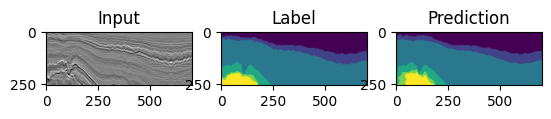

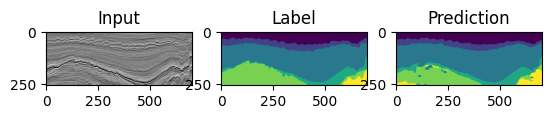

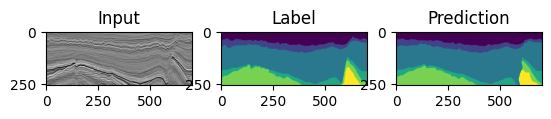

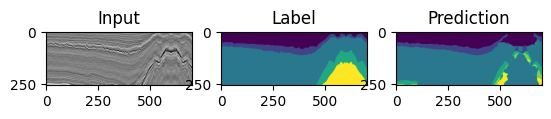

In [15]:
first_batch = next(iter(test_dl))
X, y = first_batch

# Run the model on the first batch
model.eval()
X = X.to(device)
y = y.to(device)
logits = model(X.float())
predictions = torch.argmax(logits, dim=1, keepdim=True)

# Plot results for the first batch
for i in range(len(X)):
    x_i = X[i]
    y_i = y[i]
    y_hat_i = predictions[i]
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(x_i[0, :, :].to("cpu").numpy(), cmap="gray")
    plt.title("Input")
    plt.subplot(1, 3, 2)
    plt.imshow(y_i[:, :].to("cpu").numpy().transpose(1, 2, 0))
    plt.title("Label")
    plt.subplot(1, 3, 3)
    plt.imshow(y_hat_i[0, :, :].to("cpu").numpy())
    plt.title("Prediction")
    plt.show()


Our model has been trained for 5 epochs. Notice that the training accuracy increased while the validation accuracy might have increased up to a point and then decreased again (hint: this might characterize overfitting). 

You might want to change the previous code to record the loss and accuracy values so you can plot them.

## 6. Train the model using [Pytorch Lightning](https://lightning.ai/docs/pytorch/stable/)

[Pytorch Lightning](https://lightning.ai/docs/pytorch/stable/) provides an API to facilitate training ML models with Pytorch.

Before continuing, please, read the [Lightning in 15 minues](https://lightning.ai/docs/pytorch/stable/starter/introduction.html) section of the PyTorch Lightning framework.

For this exercise, we will use the models.deeplabv3.DeepLabV3Model Lightning model.

Inspect the `models/deeplabv3.py` file and notice that the class implements the `forward`, `training_step`, `validation_step` and `configure_optimizers` methods. Also, notice that the `__init__` method defines the loss function.

In [16]:
import models.deeplabv3 as dlv3

# Create the model
model = dlv3.DeepLabV3Model(num_classes=6)

In [17]:
import lightning as L

# Create the trainer and train (fit) the model
trainer = L.Trainer(max_epochs=5, log_every_n_steps=1)
trainer.fit(model=model, train_dataloaders=train_dl, val_dataloaders=val_dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                    | Params
------------------------------------------------------
0 | backbone  | DeepLabV3Backbone       | 25.6 M
1 | pred_head | DeepLabV3PredictionHead | 16.1 M
2 | loss_fn   | CrossEntropyLoss        | 0     
------------------------------------------------------
41.7 M    Trainable params
0         Non-trainable params
41.7 M    Total params
166.736   Total estimated model params size (MB)


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 248/248 [00:20<00:00, 12.30it/s, v_num=96]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 248/248 [00:20<00:00, 11.95it/s, v_num=96]


In [18]:
model.eval()
report_accuracy(model, train_dl, prefix="    Training ")
report_accuracy(model, val_dl,   prefix="  Validation ")
report_accuracy(model, test_dl,  prefix="        Test ")

    Training  IoU = 0.9647
  Validation  IoU = 0.9598
        Test  IoU = 0.7206


#### Testing the model

Lets test the model with the test set and plot a inline to see the results.

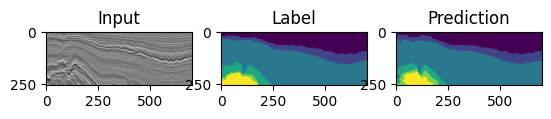

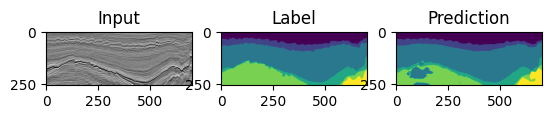

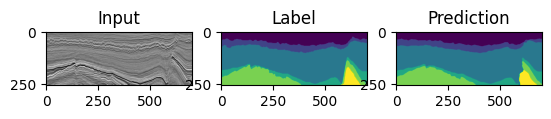

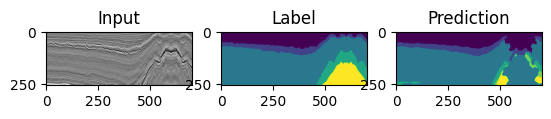

In [19]:
first_batch = next(iter(test_dl))
X, y = first_batch

# Run the model on the first batch
model.eval()
X = X.to(device)
y = y.to(device)
logits = model(X.float())
predictions = torch.argmax(logits, dim=1, keepdim=True)

# Plot results for the first batch
for i in range(len(X)):
    x_i = X[i]
    y_i = y[i]
    y_hat_i = predictions[i]
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(x_i[0, :, :].to("cpu").numpy(), cmap="gray")
    plt.title("Input")
    plt.subplot(1, 3, 2)
    plt.imshow(y_i[:, :].to("cpu").numpy().transpose(1, 2, 0))
    plt.title("Label")
    plt.subplot(1, 3, 3)
    plt.imshow(y_hat_i[0, :, :].to("cpu").numpy())
    plt.title("Prediction")
    plt.show()